The Variability of the Red Supergiant Betelgeuse: A Detailed Photometric Analysis

Author: Kumar Shivam

This notebook analyzes the light curve of Betelgeuse (Alpha Orionis) during the "Great Dimming" event of 2019-2020. It utilizes AAVSO data to perform:

1. V-Band Light Curve Analysis

2. Multi-Periodicity Detection (using Lomb-Scargle Periodograms)

3. Time-Frequency Analysis (using Continuous Wavelet Transform)

4. Color Evolution ($B-V$ Index Analysis)

1.Setup and Dependencies

Importing necessary libraries for astronomical time-series analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.timeseries import LombScargle
import pywt

print("Libraries imported successfully.")

Libraries imported successfully.


2.Configuration

Defining file paths and constants for the Great Dimming event.

In [2]:
# FILES
FILE_PATH = 'aavsodata_69258f25019da.txt'
OUTPUT_LC = 'betelgeuse_lightcurve.png'
OUTPUT_WV = 'betelgeuse_wavelet.png'
OUTPUT_BV = 'betelgeuse_color_evolution.png'

# CONSTANTS
DIM_START = 2458800   # Late 2019
DIM_END   = 2459000   # Mid 2020

3.Data Loading Functions

Functions to parse the AAVSO format, filter for V-Band and B-Band data, and synchronize timestamps for color index calculations.

In [3]:
# DATA LOADING (V-Band)
def load_vband(filepath):
    print("Loading V-Band Data...")
    try:
        df = pd.read_csv(filepath, low_memory=False)
        df['Magnitude'] = pd.to_numeric(df['Magnitude'], errors='coerce')
        df['JD'] = pd.to_numeric(df['JD'], errors='coerce')
        df = df.dropna(subset=['Magnitude', 'JD'])
        df = df[df['Band'] == 'V']
        df = df[(df['Magnitude'] > -1.0) & (df['Magnitude'] < 4.0)]
        df = df.sort_values('JD')
        recent = df[df['JD'] > 2451545].reset_index(drop=True)
        print(f"V-Band Loaded: {len(recent)} points")
        return recent
    except Exception as e:
        print(f"Error V-Band: {e}")
        return None

# DATA LOADING (Color B-V)
def load_color_data(filepath):
    print("Loading Color Data...")
    try:
        df = pd.read_csv(filepath, low_memory=False)
        df['Magnitude'] = pd.to_numeric(df['Magnitude'], errors='coerce')
        df['JD'] = pd.to_numeric(df['JD'], errors='coerce')
        df = df.dropna(subset=['Magnitude', 'JD'])

        v_data = df[df['Band'] == 'V'].sort_values('JD')
        b_data = df[df['Band'] == 'B'].sort_values('JD')

        # Merge overlapping observations within 0.5 days tolerance
        merged = pd.merge_asof(
            b_data, v_data, on='JD', suffixes=('_B', '_V'),
            tolerance=0.5, direction='nearest'
        )

        merged = merged.dropna(subset=['Magnitude_V'])
        merged['B_minus_V'] = merged['Magnitude_B'] - merged['Magnitude_V']
        merged = merged[merged['JD'] > 2451545]

        # Remove outliers
        median_bv = merged['B_minus_V'].median()
        std_bv = merged['B_minus_V'].std()
        clean = merged[np.abs(merged['B_minus_V'] - median_bv) < 2 * std_bv]

        print(f"Color Data: {len(clean)} pairs (Recovered History)")
        return clean
    except Exception as e:
        print(f"Error Color Data: {e}")
        return None

4.Analytical Methods

Lomb-Scargle Periodogram

Used to detect periodic signals in unevenly sampled data. We search for the Long Secondary Period (LSP) and the dominant pulsation period.

Continuous Wavelet Transform (CWT)

Used to visualize how the power of different frequencies changes over time. This is crucial for detecting if the pulsation period shifted during the dimming.

In [4]:
# MULTI-PERIOD ANALYSIS
def find_all_periods(t, y):
    print("\nFinding Multiple Periodicities...")
    search_windows = [
        ("Long Secondary Period (LSP)", 1500, 3500),
        ("Dominant Variability (~400 d)", 300, 550),
        ("Shorter Variability (~250 d)", 180, 300),
        ("Short Timescale (~150 d)", 100, 180)
    ]

    found_periods = {}
    residuals = y.copy()

    for name, min_p, max_p in search_windows:
        freqs = np.linspace(1 / max_p, 1 / min_p, 10000)
        ls = LombScargle(t, residuals)
        power = ls.power(freqs)
        best_period = 1.0 / freqs[np.argmax(power)]
        y_model = ls.model(t, 1.0 / best_period)
        residuals = residuals - (y_model - np.mean(y_model))
        found_periods[name] = best_period
        print(f"→ Found {name}: {best_period:.2f} days")

    return found_periods

#  WAVELET ANALYSIS
def run_wavelet(t, y):
    """
    Robust continuous wavelet transform for irregular astronomical time series.

    Steps:
    1. Interpolation to uniform time grid
    2. Log-scaled power for balanced visibility
    3. period conversion using PyWavelets frequencies
    """

    # 1. Uniform time grid
    dt = 1.0  # days
    t_grid = np.arange(t.min(), t.max(), dt)

    # 2. Interpolate & detrend
    y = y - np.mean(y)
    interp = interp1d(t, y, kind='linear', fill_value='extrapolate')
    y_grid = interp(t_grid)

    # 3. Define wavelet scales
    # Covers ~100–3000 day periods
    scales = np.logspace(np.log10(50), np.log10(3000), 200)

    # 4. Continuous Wavelet Transform
    coeffs, freqs = pywt.cwt(
        y_grid,
        scales,
        'cmor1.5-1.0',
        sampling_period=dt
    )

    # 5. Convert frequencies to periods
    periods = 1.0 / freqs

    # 6. Variance-normalized wavelet power
    power = (np.abs(coeffs) ** 2) / np.var(y_grid)

    # 7. Log power
    power = np.log10(power + 1e-6)

    return t_grid, periods, power

5.Main Execution

Loading the data and running the period detection.

In [5]:
df_v = load_vband(FILE_PATH)
df_color = load_color_data(FILE_PATH)

if df_v is not None:
    t = df_v['JD'].values
    y = df_v['Magnitude'].values

    # Period analysis
    periods_dict = find_all_periods(t, y)
    dom_period = periods_dict.get("Dominant Variability (~400 d)", 400.0)
else:
    print("Error in processing data.")
    print("If the file is already present, Please check for file path.")


Loading V-Band Data...
V-Band Loaded: 2414 points
Loading Color Data...
Color Data: 301 pairs (Recovered History)

Finding Multiple Periodicities...
→ Found Long Secondary Period (LSP): 2181.96 days
→ Found Dominant Variability (~400 d): 397.99 days
→ Found Shorter Variability (~250 d): 215.50 days
→ Found Short Timescale (~150 d): 140.24 days


6.Visualization

Plot 1: V-Band Light Curve

Highlights the Great Dimming phase and the dominant variability timescale.

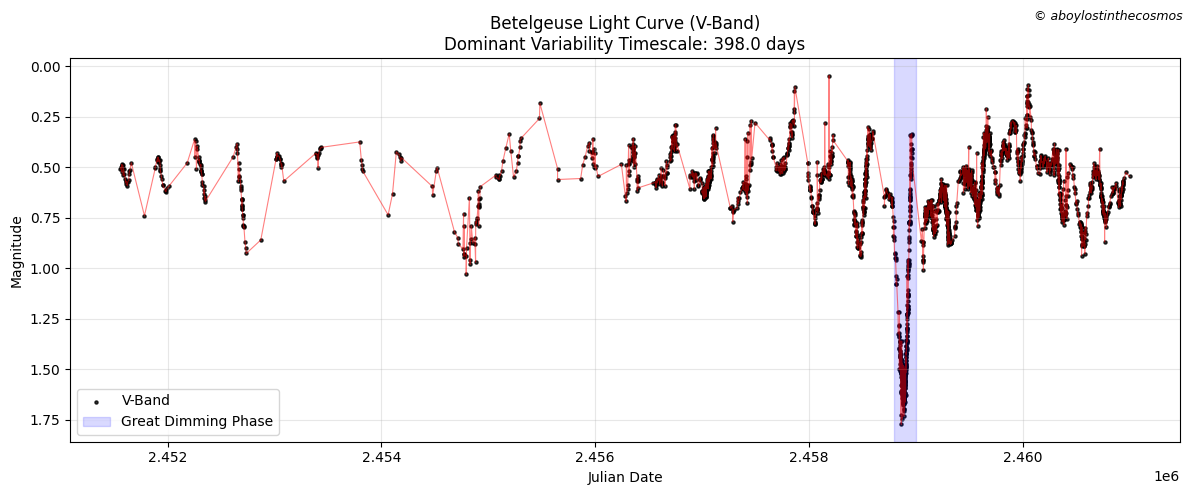

Saved: betelgeuse_lightcurve.png


In [6]:
if df_v is not None:
    plt.figure(figsize=(12, 5))
    plt.plot(t, y, '-', color='red', alpha=0.5, linewidth=0.8)
    plt.scatter(t, y, color='black', s=5, alpha=0.8, label='V-Band')

    plt.axvspan(DIM_START, DIM_END, color='blue', alpha=0.15, label='Great Dimming Phase')

    plt.gca().invert_yaxis()
    plt.title(
        f'Betelgeuse Light Curve (V-Band)\n'
        f'Dominant Variability Timescale: {dom_period:.1f} days'
    )
    plt.xlabel('Julian Date')
    plt.ylabel('Magnitude')
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.figtext(0.99, 0.98, '© aboylostinthecosmos', ha='right', va='top', fontsize=9, style='italic')
    plt.tight_layout()
    plt.savefig(OUTPUT_LC)
    plt.show()
    print(f"Saved: {OUTPUT_LC}")

Plot 2: Wavelet Power Spectrum

Visualizing the evolution of variability timescales (periods) over the years.

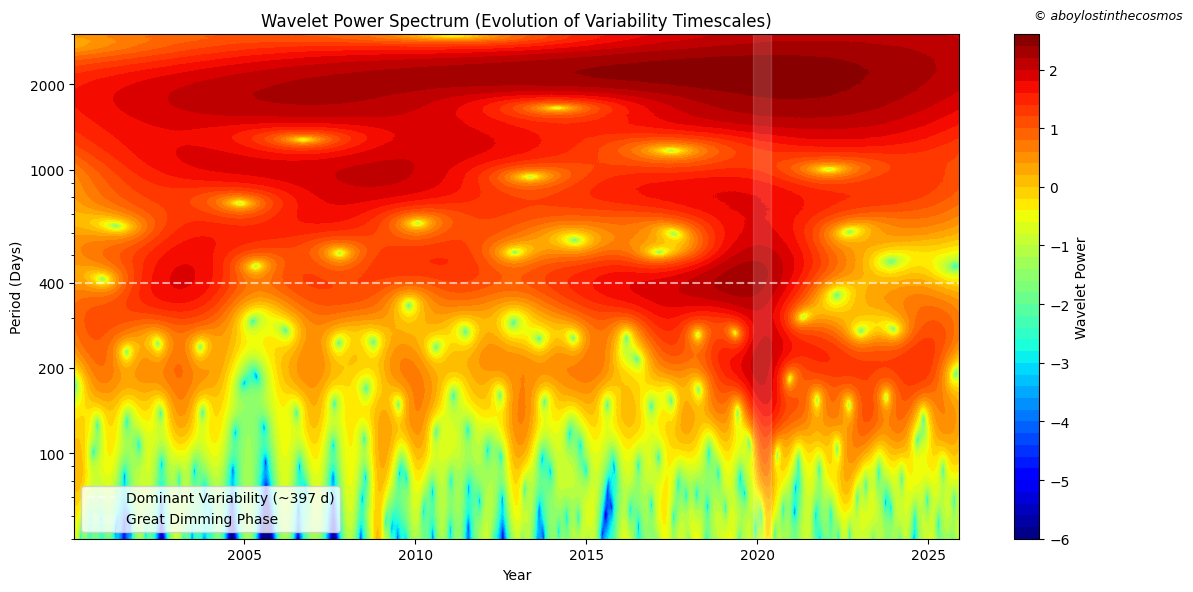

Saved: betelgeuse_wavelet.png


In [7]:
if df_v is not None:
    t_grid, periods, power = run_wavelet(t, y)
    years = (t_grid - 2451545.0) / 365.25 + 2000

    plt.figure(figsize=(12, 6))
    X, Y = np.meshgrid(years, periods)
    c = plt.contourf(X, Y, power, levels=50, cmap='jet')
    plt.yscale('log')
    plt.yticks([100, 200, 400, 1000, 2000], ['100', '200', '400', '1000', '2000'])

    plt.axhline(dom_period, color='white', linestyle='--', alpha=0.6,
                label=f'Dominant Variability (~{int(dom_period)} d)')

    dim_start_yr = (DIM_START - 2451545.0) / 365.25 + 2000
    dim_end_yr   = (DIM_END - 2451545.0) / 365.25 + 2000
    plt.axvspan(dim_start_yr, dim_end_yr, color='white', alpha=0.15, label='Great Dimming Phase')

    plt.title('Wavelet Power Spectrum (Evolution of Variability Timescales)')
    plt.ylabel('Period (Days)')
    plt.xlabel('Year')
    plt.colorbar(c, label='Wavelet Power')
    plt.legend(loc='lower left')
    plt.figtext(0.99, 0.98, '© aboylostinthecosmos', ha='right', va='top', fontsize=9, style='italic')
    plt.tight_layout()
    plt.savefig(OUTPUT_WV)
    plt.show()
    print(f"Saved: {OUTPUT_WV}")

Plot 3: Color Evolution (B-V)

Tracking the reddening of the star using the $B-V$ index. Higher values indicate redder (cooler or dustier) conditions.

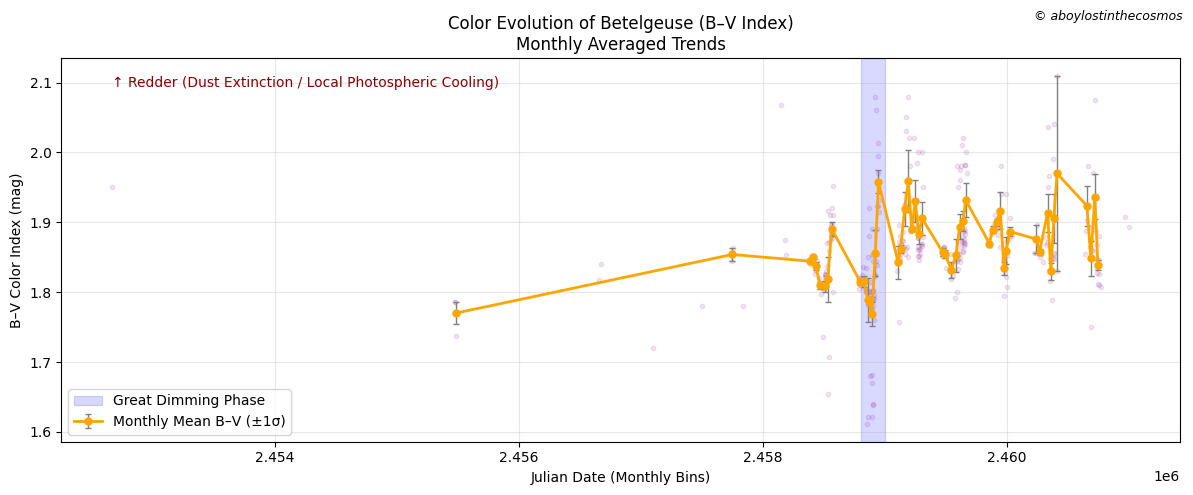

Saved: betelgeuse_color_evolution.png


In [8]:
if df_v is not None:
    if df_color is not None and not df_color.empty:
        plt.figure(figsize=(12, 5))
        plt.scatter(df_color['JD'], df_color['B_minus_V'], color='purple', s=10, alpha=0.1)

        bins = np.arange(df_color['JD'].min(), df_color['JD'].max(), 30)
        df_color['bin'] = pd.cut(df_color['JD'], bins)
        monthly = df_color.groupby('bin', observed=True).agg({
            'JD': 'mean',
            'B_minus_V': ['mean', 'sem']
        }).dropna()

        x_bin = monthly['JD']['mean']
        y_bin = monthly['B_minus_V']['mean']
        y_err = monthly['B_minus_V']['sem']

        plt.errorbar(x_bin, y_bin, yerr=y_err, fmt='o-', color='orange',
                     ecolor='gray', elinewidth=1, capsize=2, linewidth=2, markersize=5,
                     label='Monthly Mean B–V (±1σ)')

        plt.axvspan(DIM_START, DIM_END, color='blue', alpha=0.15, label='Great Dimming Phase')

        y_max = df_color['B_minus_V'].max()
        plt.text(
            df_color['JD'].min(), y_max,
            '↑ Redder (Dust Extinction / Local Photospheric Cooling)',
            color='darkred', fontsize=10, va='top'
        )

        plt.title('Color Evolution of Betelgeuse (B–V Index)\nMonthly Averaged Trends')
        plt.xlabel('Julian Date (Monthly Bins)')
        plt.ylabel('B–V Color Index (mag)')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.figtext(0.99, 0.98, '© aboylostinthecosmos', ha='right', va='top', fontsize=9, style='italic')
        plt.tight_layout()
        plt.savefig(OUTPUT_BV)
        plt.show()
        print(f"Saved: {OUTPUT_BV}")

    else:
        print("Not enough B and V overlapping data for Color Plot.")
